[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/k-spaces/blob/main/model_fitting_examples.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import kspaces
except ImportError:
        !pip install kspaces
        import kspaces

This notebook has examples of:

- generating synthetic data
- fitting a model
- assigning new points to existing subspaces after a model has been fit
- constructing affine_subspace objects directly
- model selection

and explanations for:

- kspaces.EM.run_EM
- kspaces.EM.E_step
- kspaces.EM.fit_single_space
- kspaces.affine_subspace_.affine_subspace
- kspaces.affine_subspace_.fixed_space
- kspaces.generate_.generate_points_subspace
- kspaces.generate_.generate
- kspaces.model_selection_.model_selection

A plotting function

In [2]:
def plot_3D(points,spaces, axis_labels = ('','',''),title = '', equal_dims = True, color_probabilities = [], f = '', el = 70, az = 20, sd_length = None):
    """create a 3D plot with matplotlib"""
    # Create figure and subplots
    fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': '3d'})
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    
    colors = np.array(['crimson', 'blue', 'darkorange', 'green', 'violet','brown'])
    point_colors = np.array(['palevioletred', 'lightskyblue', 'sandybrown', 'mediumseagreen', 'mediumorchid','khaki'])

    xlim = [min(x), max(x)]
    ylim = [min(y), max(y)]
    zlim = [min(z),max(z)]
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_title(title)
    

    #plot points
    ax.scatter(x, y, z, color=kspaces.plotting.color_by_cluster(color_probabilities, point_colors), marker='o', alpha = 1, s = 1)

    if equal_dims:
        ax.set_aspect('equal')
    #plot the fitted spaces
    for idx, space in enumerate(spaces):
        c = colors[idx%len(colors)]
        style = '-'
        if space.d == 0:
            kspaces.plotting.plot_point_3D(ax, xlim, ylim, zlim, space, color=c)
        elif space.d == 1:
            kspaces.plotting.plot_line_3D(ax, xlim, ylim, zlim, space, color=c, linestyle=style, sd_length = sd_length)
        elif space.d ==2:
            kspaces.plotting.plot_plane(ax, xlim, ylim, zlim, space, color=c)

    # Set different viewing angles
    ax.view_init(elev=el, azim=az)


    # Adjust layout and display

    if f != '':
        plt.savefig(f)
    plt.show()

In [3]:
plt.rcParams['grid.color'] = "lightgray"

# Generate a toy dataset

kspaces.generate_.generate_points_subspace() accepts vectors and a single, isotropic within subspace standard deviation for latent points and a single, isotropic standard deviation for noise. It is a quick way to generate synthetic data. kspaces.generate_.generate() accepts a list of k-spaces affine subspaces and offers more flexibility.

```python
def generate_points_subspace(translation, vectors, size, dist_std = 3, noise_std=0.1):
    """generates points from translation and basis vectors rather than using the affine_subspace objects. Using generate() instead with affine_subspace objects is recommended.

    generates normally distributed points in an affine subspace and then perturbs with isotropic normal noise (variance = sqrt(noise_std) in each of the D dimensions). 
    note: isotropic noise is added to latent space as well, so fitting k-spaces will not return latent_sigma equal to dist_std. it will be sqrt(dist_std ^2 + noise_std^2)

    translation: list of length D. the mean of points (and also a translation vector for the affine subspace)
    vectors: k x D list of lists. basis vectors for the affine subspace.
    size: the number of synthetic points to generate.
    dist_std: standard deviation for normal distribution of coefficients to multiply basis vectors by
    noise_std: standard deviation for isotropic noise.

    returns: N x D array of points"""
```

In [4]:
np.random.seed(0)

Make a data from 4 subspaces:

In [5]:
t1 = [2,2,0]
v1 = [[1,0,0],[0,1,0.3]]
X1 = kspaces.generate_.generate_points_subspace(t1, v1, 4000, dist_std = 4, noise_std=0.1)
s1 = kspaces.affine_subspace(v1, t1, 0.1, [3,3], 0)
c1 =[[1,0,0,0]]*4000

In [6]:
t2 = [0,6,6]
v2 = [[1,1,1]]
X2 = kspaces.generate_.generate_points_subspace(t2, v2, 200, dist_std = 6, noise_std=0.1)
s2 = kspaces.affine_subspace(v2, t2, 0.1, [3], 0)
c2 = [[0,1,0,0]]*200

In [7]:
t3 = [7,-8,9]
v3 = []
X3 = kspaces.generate_.generate_points_subspace(t3, v3, 100, dist_std = 3, noise_std=2)
s3 = kspaces.affine_subspace(v3, t3, 0.5, [], 0)
c3 = [[0,0,1,0]]*100

In [8]:
t4 = [0,6,3]
v4 = [[-1,1,3]]
X4 = kspaces.generate_.generate_points_subspace(t4, v4, 300, dist_std = 5, noise_std=1)
s4 = kspaces.affine_subspace(v4, t4, 0.4, [5], 0)
c4 = [[0,0,0,1]]*300

**Show ground truth data**

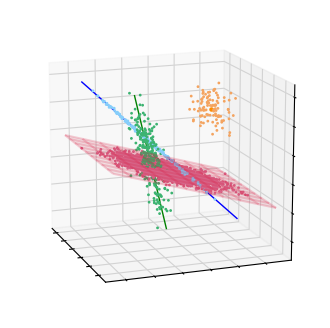

In [9]:
X = np.concatenate([X1,X2,X3,X4], axis = 0)
plot_3D(X, [s1,s2,s3,s4], color_probabilities = np.concatenate([c1,c2,c3,c4], axis = 0), el = 15, az = 160)

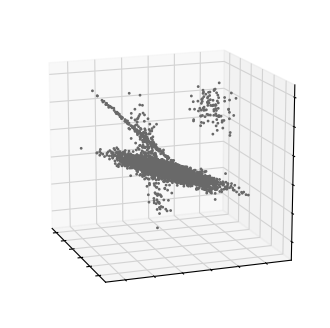

In [10]:
X = np.concatenate([X1,X2,X3,X4], axis = 0)
plot_3D(X, [], color_probabilities = [], el = 15, az = 160)

# Fit a model

**run_EM** is the general all-purpose wrapper for fitting models with k-spaces. It takes in data and model hyperparameters and returns a k-spaces model (a list of fitted subspaces and their probability distributions) and a matrix of probabilistic assignments of points to subspaces.

The only required arguments are '**points**' (the data) and '**kd**' (a list of length k, where each entry specifies the dimension of a subspace), but '**assignment**', '**max_iter**', '**tol**', and '**intializations**' should be chosen based on context too. 

'**fixed_spaces**' or '**init_spaces**' are useful in some contexts, as is '**DA**' (deterministic annealing), though these are more advanced options. 

'**fixed_spaces**' is a list of '**fixed_space**' objects, which inherit the properties of the '**affine_subspace**' class but their M-step does not adjust the basis vectors or translation for the subspace (i.e., the subspace is 'fixed'). The probability distribution-related parameters do get updated in the EM process though. '**init_spaces**' is a list specifying a starting k-spaces model to do an EM initialization with. It overrides '**kd**', but random initialiations will follow and the best model will be returned if '**intializations**' is not set to 1. '**DA**' and the '**beta**' and '**anneal_rate**' arguments are for deterministic annlealing, which can improve chances of finding the global optimal solution but is slower because EM must be reinitialized more times. (Naonori Ueda and Ryohei Nakano. Deterministic annealing EM algorithm. Neural Networks, 11(2):271–282, March 1998.)


```python
def run_EM(points, 
       kd, 
       assignment = 'soft', 
       max_iter=50, 
       tol=5e-2, 
       initializations = 10, 
       verbose = False, 
       silent = False, 
       print_solution = False, 
        randomize_init = False, 
       batch_size = np.inf, 
       batch_replace = True, 
       print_ownerships = False,
       multiprocess_spaces = False, 
       init_spaces = [], 
       fixed_spaces = [], 
       min_variance = 1e-10, 
       return_if_failed = True,
      set_noise_equal = False, 
       DA = False, 
       beta_0 = 0.5, 
       anneal_rate = 1.2):
    """ Runs EM with multiple initializations and selects the maximum likelihood one.
    The first initialization uses kmeans to get centroids and then passes lines through those and the origin.
    
    returns: spaces (list of affine subspaces), probabilities (N x K np array of P(space | point))
    
    kd: 1 x k list containing dimensions (d) for subspaces. i.e. [1,1,1] or [0,2,1]
    assignment: default "hard". Other options: "soft" and "closest".
    fixed spaces: list of dicts {'vec':[basis],'tr':translation} where basis vectors and translation are all lists of length D
    init spaces: list of affine_subspaces (see affine_subspace_.py) to intialize with.
    max_iter: maximum number of EM iterations
    tol: default 0.05. tolerance for determining EM convergence.
    initializations: default 1. 5-10 is recommended. Number of EM initializations to do. 
    verbose: default False (recommended). Optionally can be set to True to print out 
        information about spaces in each EM iteration as EM converges.
    print_solution: default False. Print out the spaces. You can also print the spaces out with print(space), 
        and the space's principal axes, translation, latent space standard deviations, complementary space 
            noise standard deviation, and total ownership of points (prior) will be displayed.
    multiprocess_spaces = default False. Process each space in parallel in the M step of EM. Useful if fitting 
        many spaces, but if doing many separate kspaces runs (i.e. running kspaces on 100 different pairs of genes) 
        it will be faster to write a wrapper to run kspaces itself in parallel as multiprocessing in python has overhead.
    batch_size: default is np.inf (no batch; use full dataset) batch size for EM iterations. 
    batch_replace: default is True. Sample with/without replacement if using batches.
    min_variance: default is 1e-10. Minimum variance enforced to prevent singular covariance matrices in 
        "soft" and "hard" assignment mode.
    return_if_failed: default True. Returns [spaces, probabilities] for last EM run if True. Returns [[],[]] if False.
    set_noise_equal: default False. If true, enforces equal sigma_noise for each space after each M step.
    DA: default False. if True, use deterministic annealing EM (Naonori Ueda and Ryohei Nakano. 
        Deterministic annealing EM algorithm. Neural Networks, 11(2):271–282, March 1998.) Will take longer to run.
        higher beta_0 and higher anneal_rate lead to faster convergence. 
    beta_0: default 0.5. ignored if DA = False. Must be between 0 and 1. Inverse to initial annealing 
        "temperature." Lower beta_0 is "hotter"
    anneal_rate: default 1.2. ignored if DA = False. Must be > 1. Factor to cool down temperature 
        per round (multiplied to beta_0 successively to reach beta = 1).
    """
```

Converged on iteration 24
Converged on iteration 18
Converged on iteration 8
Converged on iteration 13
Converged on iteration 27
Converged on iteration 19
Failed on iteration 10: a space was eliminated
Converged on iteration 46
Converged on iteration 12
Converged on iteration 25
time per EM run: 0.08
time per E, M step : [0.0009 0.0029]


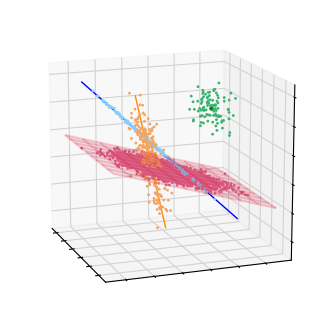

In [11]:
spaces_correct, probabilities = kspaces.run_EM(X, [2,1,1,0], max_iter = 50, assignment = 'hard', initializations = 10, randomize_init = True)
plot_3D(X, spaces_correct, color_probabilities = probabilities, el = 15, az = 160,)

An affine subspace can be fit individually to data as well using kspaces.EM.fit_single_space, a wrapper for affine_subspace.fit

```python
def fit_single_space(points,d, min_variance = 1e-10):
    """ fits a single space with PCA
    points: N x D array
    d: int. dimension of space to fit
    min_variance: float. minimum variance added if variance along a dimension is zero to avoid a singular covariance matrix

    returns: affine_subspace"""
```

# Walk through the EM process

This only uses 1 initialization (the default for kspaces.run_EM) so we can isolate the results of each initialization and compare them. In practice, we would never do this as this EM is only guaranteed to converge to local minima.

**seed = 0 and seed = 1 did not converge on the correct solution. Again, in practice we would never use run_EM like this and would always use multiple initializations.** These two examples will be shown below under "other initializations that didn't work"

Initialization

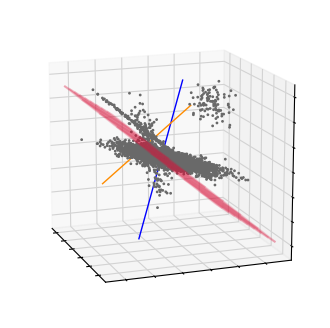

In [12]:
np.random.seed(2)
spaces = kspaces.EM.init(X, D = 3, kd = [2,1,1,0])
probabilities = kspaces.E_step(X, spaces, assignment = 'soft')
plot_3D(X, spaces, color_probabilities = [], el = 15, az = 160)

E step after initialization

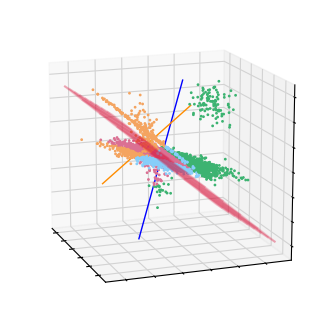

In [13]:
np.random.seed(2)
spaces = kspaces.EM.init(X, D = 3, kd = [2,1,1,0])
probabilities = kspaces.E_step(X, spaces, assignment = 'soft')
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160)

Max_iter = 1 so we can see how this looked after 1 round of EM.

max iteration 1 completed
time per EM run: 0.006
time per E, M step : [0.0011 0.0035]


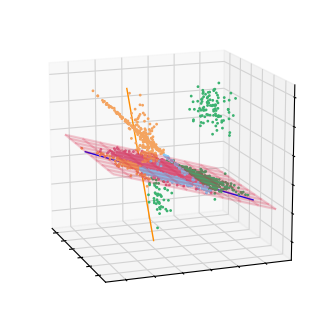

In [14]:
np.random.seed(2)
spaces, probabilities = kspaces.run_EM(X, kd = [2,1,1,0], max_iter = 1, assignment = 'hard', initializations = 1,randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160)

Max_iter = 4 (same example) so we can see how this looked after the 4th round of EM.

max iteration 4 completed
time per EM run: 0.018
time per E, M step : [0.001  0.0031]


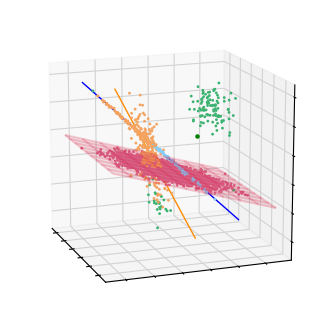

In [15]:
np.random.seed(2)
spaces, probabilities = kspaces.run_EM(X, kd = [2,1,1,0], max_iter = 4, assignment = 'hard',initializations = 1, randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160,)

Final:

Converged on iteration 8
time per EM run: 0.034
time per E, M step : [0.0009 0.003 ]


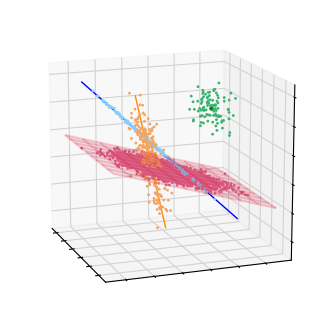

In [16]:
np.random.seed(2)
spaces, probabilities = kspaces.run_EM(X, kd = [2,1,1,0], max_iter = 50, assignment = 'hard', initializations = 1, randomize_init = True)
plot_3D(X, spaces, color_probabilities = probabilities, el = 15, az = 160,)

# How to generate synthetic data from a fitted kspaces model

kspaces.generate_.generate can be used to generate data from a k-spaces model. It accepts a list of affine subspaces, which can either be the result of fitting a k-spaces model or you can make your own affine_subspace objects and put them together in a list for more flexibility than kspaces.generate_.generate_points_subspace.

Also, each affine subspace has its own generate() method that you can use too. It only accepts a size argument.

```python        
def generate(spaces,size = 1, seed = None):
    """generates points given a list of affine_subspaces

    spaces: list of affine_subspaces (or a single affine subspace)
    size: default 1. number of data points
    seed: default None. random seed for numpy

    returns size x D array of points, where D is specified by the spaces.
    """
```

**Make synthetic data using the fitted model**

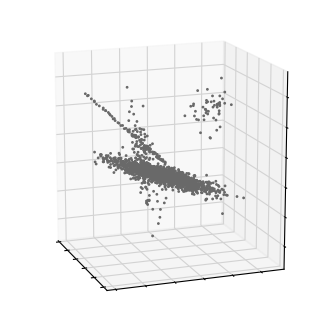

In [17]:
X_sim = kspaces.generate(spaces_correct, size = 2000, seed = 0)
plot_3D(X_sim, [], color_probabilities = [], el = 15, az = 160, f = '')

# How to make affine_subspace objects directly and use those to make synthetic data

```python          
class affine_subspace:
    def __init__(self,vectors, translation, sigma, latent_sigmas, prior):
        """ initializes affine subspace
        vectors: d x D list of lists
        translation: list of length D
        sigma: nonnegative scalar
        latent_sigmas: list of length d
        prior: scalar from 0 to 1
        """
        self.vectors = self.vectors_to_orthonormal_basis(np.array(vectors)) #associated vector subspace is spanned by these basis vectors
        self.translation = np.array(translation) #translation vector for "origin" of the subspace
        self.sigma = sigma #standard deviation of orthogonal noise averaged over dimensions of complementary space
        self.latent_sigmas = np.array(latent_sigmas) #standard deviations for data along each eigenvector of the latent space
        self.D = len(translation) #dimensionality of ambient space
        self.d = len(vectors) #dimensionality of subspace
        self.prior = prior #mixture component weight for this subspace. All subspaces' priors add up to 1
```

An affine subspace is **constructed** with the following arguments: vectors, translation, sigma, latent_sigmas, prior. 

'**d**' refers to the subspace dimension. Its specified indirectly through the length of the vectors list, and it is the degrees of freedom for moving around the affine subspace. 

'**D**' is the ambient dimension and is the dimension of the space the subspace 'lives' in... a line (a 1D subspace) can exist within a sheet of paper (a 2D space) or in our 3D world.

'**translation**' is what makes our subspace affine. A line passing through the origin of a graph, such as y = 2x, is a vector subspace, while a line not passing through the origin is an affine subspace, such as y = 2x + 1. Any point on that y = 2x + 1 line would work as a translation, but for a k-spaces affine_subspace object, translation also specifies the mean of the probability distribution within the subspace.

'**vectors**' is a list of lists specifying vectors that span the subspace. Its length specifies 'd'. The length of each list within vectors should be 'D'. For a 0-dimensional subspace (d=0) 'vectors' is simply this empty list '[]' and len([]) is 0. Otherwise, it should look something like this 'vectors = [[0,1,0],[1,0,0]]'. These vectors do not need to be unit vectors (length of 1) or an orthonormal basis (orthogonal to each other), because the object's constructor will handle this. If they are linearly dependednt and therefore do not span a subspace of dimension d, a random vector will be added.

'**sigma**' is the standard deviation for the isotropic Gaussian distribution in the complementary space (aka the D - d dimensional space that is outside of the subspace)

'**latent_sigmas**' is a list of length 'd' that gives the standard deviations for the multivariate Gaussian within the subspace

'**prior**' is the mixture component weight for this subspace. It is the prior probability that a point belongs to this subspace before seeing its coordinates.

===============================================================================================================================================================

An affine_subspace instance has the following **data attributes** (plus many methods):

'**d**' int. subspace dimension

'**D**' int. ambient space dimension

'**translation**' numpy array. mean of the distribution

'**vectors**' 2-D numpy array. orthonormal basis vectors

'**sigma**' float. sigma > 0

'**latent_sigmas**' numpy array. latent_sigmas > 0

'**prior**' float. 0 < prior <= 1

In [18]:
#the length of this vector determines the dimension of the affine_subspace's ambient space, here D = 3
translation = [0,-4,0] 

#the noise for points
sigma = 0.2 

#the displacement within the subspace for points
latent_sigmas = [1] 

#make a 1-dimensional subspace (aka a line)
#this will be rescaled to a unit vector by the constructor
vector = [1,-2,3] 
vectors = [vector] #the constructor  expects a list of vectors, even for a subspace with d = 1

#the mixture weight for this component of the model
prior = 0.7

#make the affine_subspace
s1 = kspaces.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

In [19]:
# make a 0-dimensional subpace
translation = [10,0,0]
sigma = 0.1
latent_sigmas = [] #empty list
vectors = [] #empty list
prior = 0.2
s2 = kspaces.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

In [20]:
# make a 2-dimensional subpace
translation = [0,0,0]
sigma = 0.1
latent_sigmas = [1.1,2.5]
vectors = [[1,1,1],
          [1,-1,1]] #empty list
prior = 0.1
s3 = kspaces.affine_subspace(vectors,translation,sigma, latent_sigmas, prior)

**Make some synthetic data and plot it**

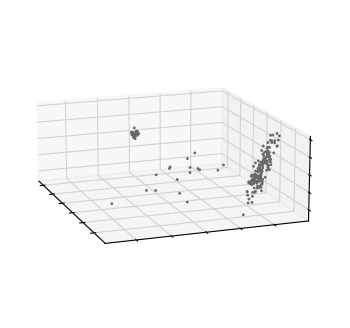

In [21]:
X_sim_2 = kspaces.generate([s1,s2,s3], size = 200, seed = 0)
plot_3D(X_sim_2, [], el = 15, az = 160, f = '')

# How to assign points or compute their ownership using kspaces.EM.E_step

We fit the model to X, but we have this new data from X_sim. We can compute the probability that each space generated each point with another expectation step.

In [22]:
probs = kspaces.E_step(X_sim, spaces_correct, assignment = 'soft') 
np.round(probs[:30], 2)

array([[1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.99, 0.  , 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.97, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.99, 0.  , 0.01, 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

Or we can use hard assignment

In [23]:
probs = kspaces.E_step(X_sim, spaces_correct, assignment = 'hard') 
probs[:30]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

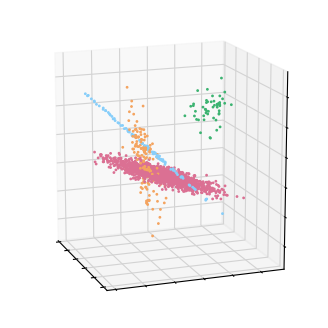

In [24]:
plot_3D(X_sim, [], color_probabilities = probs, el = 15, az = 160, f = '')

# Other EM initializations that didn't work on the toy example:

Not every EM run converges on the globally optimal solution, which, by the way, may not be identical to the "ground truth" parameters used to generate the data. The globally optimal solution is the solution with the highest likelihood for the observed data with the specified model hyperparameters. That's it.

**Here are examples of locally optimal solutions that are not globally optimal, which is why we initialize EM many times in practice.**

Converged on iteration 29
time per EM run: 0.119
time per E, M step : [0.0009 0.0031]


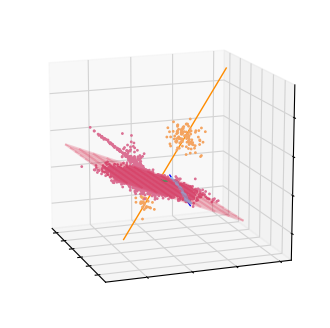

In [25]:
np.random.seed(0)
spaces0, probabilities0 = kspaces.run_EM(X, kd = [2,1,1,0], max_iter = 50, initializations = 1, assignment = 'hard', randomize_init = True)
plot_3D(X, spaces0, color_probabilities = probabilities0, el = 15, az = 160 , sd_length = 3)

Converged on iteration 12
time per EM run: 0.054
time per E, M step : [0.001  0.0033]


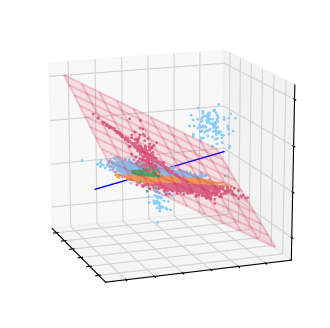

In [26]:
np.random.seed(1)
spaces1, probabilities1 = kspaces.run_EM(X, kd = [2,1,1,0], max_iter = 50, initializations = 1, assignment = 'hard', randomize_init = True)
plot_3D(X, spaces1, color_probabilities = probabilities1, el = 15, az = 160, sd_length = 3)

# Misspecify kd to get some other examples for model selection

Converged on iteration 10
time per EM run: 0.045
time per E, M step : [0.001  0.0031]


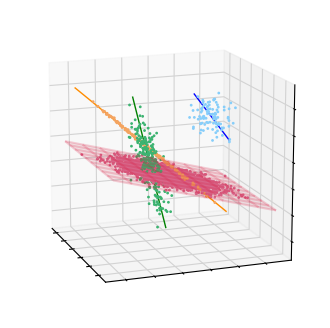

In [27]:
np.random.seed(1)
spaces_extra, probabilities = kspaces.run_EM(X, kd = [2,1,1,1], max_iter = 50, initializations = 1, assignment = 'hard', randomize_init = True)
plot_3D(X, spaces_extra, color_probabilities = probabilities, el = 15, az = 160, sd_length = 3)

Converged on iteration 31
time per EM run: 0.108
time per E, M step : [0.0009 0.0024]


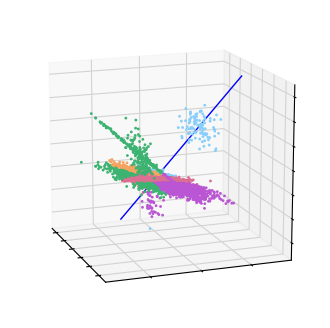

In [28]:
np.random.seed(1)
spaces_under, probabilities = kspaces.run_EM(X, kd = [1,1,0,0,0], max_iter = 50, initializations = 1, assignment = 'hard', randomize_init = True)
plot_3D(X, spaces_under, color_probabilities = probabilities, el = 15, az = 160, sd_length = 3)

In [29]:
alternates = [spaces0, spaces1, spaces_extra, spaces_under]
for a in alternates:
    print('seed 2 vs alternate solution:')
    kspaces.model_selection(X, spaces_correct, a)
    print('vice versa - alternate solution vs seed 2')
    kspaces.model_selection(X, a, spaces_correct)
    print()

seed 2 vs alternate solution:
Same degrees of freedom: model has higher likelihood
vice versa - alternate solution vs seed 2
Same degrees of freedom: model does not have higher likelihood than null

seed 2 vs alternate solution:
Same degrees of freedom: model has higher likelihood
vice versa - alternate solution vs seed 2
Same degrees of freedom: model does not have higher likelihood than null

seed 2 vs alternate solution:
BIC model is lower
47696.43092315864 < 47716.69942305493
vice versa - alternate solution vs seed 2
BIC model is not lower

seed 2 vs alternate solution:
BIC model is lower
47696.43092315864 < 69721.3737461844
vice versa - alternate solution vs seed 2
BIC model is not lower



(The printed message is different for the top two because when the model specification is the same (kd is the same for both), we can just compare the likelihood).

In [30]:
alternates = [spaces0, spaces1, spaces_extra, spaces_under]
for a in alternates:
    print('seed 2 vs alternate solution:')
    kspaces.model_selection(X, spaces_correct, a, test = 'ICL')
    print('vice versa - alternate solution vs seed 2')
    kspaces.model_selection(X, a, spaces_correct, test = 'ICL')
    print()

seed 2 vs alternate solution:
ICL model is lower
47765.783137285995 < 68563.97231072364
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.783137285995 < 71190.58229299694
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.783137285995 < 47786.05163587371
vice versa - alternate solution vs seed 2
ICL model is not lower

seed 2 vs alternate solution:
ICL model is lower
47765.783137285995 < 71057.35567005014
vice versa - alternate solution vs seed 2
ICL model is not lower



# More model selection examples on another toy dataset

## example 1

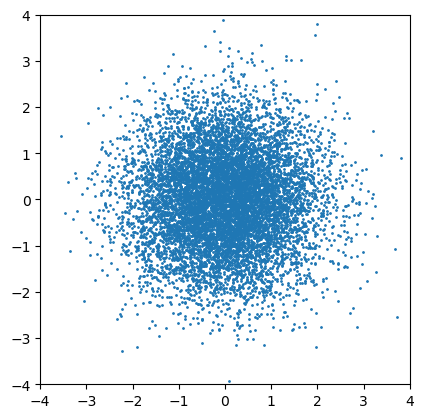

In [31]:
ground_truth = [kspaces.affine_subspace([],[0,0],1,[],1)]
points= kspaces.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
ax.set_aspect('equal')

In [32]:
s0 = kspaces.fit_single_space(points,0) #point
p0 = np.array([[1]]*10000)

In [33]:
s1 = kspaces.fit_single_space(points,1) #line
p1 = np.array([[1]]*10000)

**line > point**

In [34]:
kspaces.model_selection(points, [s1], [s0])

BIC model is not lower


'null'

**Reject two points in favor of one**

In [35]:
s0 = kspaces.fit_single_space(points,0) #one point
p0 = np.array([[1]]*10000)

In [36]:
s1, p1 = kspaces.run_EM(points,[0,0],assignment = 'soft', max_iter = 3) #two points

max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
time per EM run: 0.007
time per E, M step : [0.0008 0.0011]


In [37]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

0

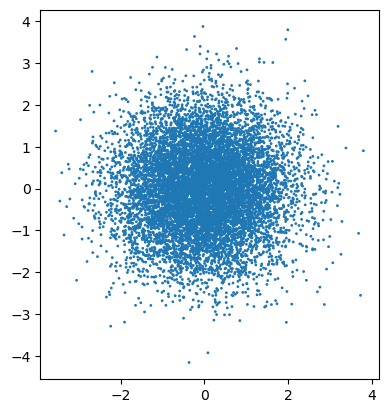

In [38]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [39]:
kspaces.model_selection(points, s1, [s0])

BIC model is not lower


'null'

## example 2

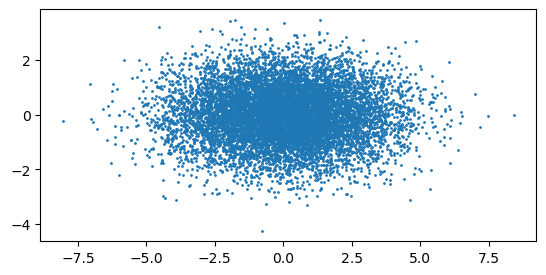

In [40]:
ground_truth = [kspaces.affine_subspace([[1,0]],[0,0],1,[2],1)]
points = kspaces.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

In [41]:
s0 = kspaces.fit_single_space(points,0) #one point
p0 = np.array([[1]]*10000)

In [42]:
s1 = kspaces.fit_single_space(points,1) #one line
p1 = np.array([[1]]*10000)

**line > point**

In [43]:
kspaces.model_selection(points, [s1], [s0])

BIC model is lower
70791.20853919112 < 75395.14082480225


'model'

**two lines are not better that one line**

In [44]:
s0 = kspaces.fit_single_space(points,1) #one line
p0 = np.array([[1]]*10000)

In [45]:
s1, p1 = kspaces.run_EM(points,[1,1],assignment = 'soft', max_iter = 3) #two lines

max iteration 3 completed
Converged on iteration 2
max iteration 3 completed
Converged on iteration 3
Converged on iteration 3
Converged on iteration 3
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
max iteration 3 completed
time per EM run: 0.015
time per E, M step : [0.0011 0.0011]


In [46]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

103

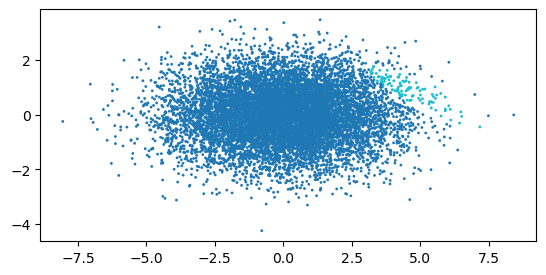

In [47]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [48]:
kspaces.model_selection(points, s1, [s0])

BIC model is not lower


'null'

## example 3

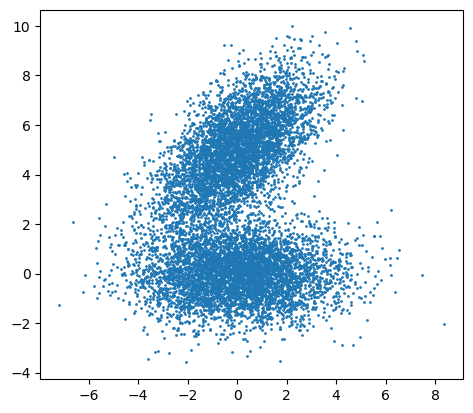

In [49]:
ground_truth = [kspaces.affine_subspace([[1,0]],[0,0],1,[2],1), kspaces.affine_subspace([[1,1]],[0,5],1,[2],1) ]
points= kspaces.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

**two lines are better than one**

In [50]:
s0 = kspaces.fit_single_space(points,1) #one line
p0 = np.array([[1]]*10000)

In [51]:
s1, p1 = kspaces.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 10) #two lines

Converged on iteration 42
Converged on iteration 27
Converged on iteration 29
Converged on iteration 46
Converged on iteration 86
Converged on iteration 64
Converged on iteration 32
Converged on iteration 38
Converged on iteration 43
Converged on iteration 39
time per EM run: 0.106
time per E, M step : [0.0011 0.0011]


In [52]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

4892

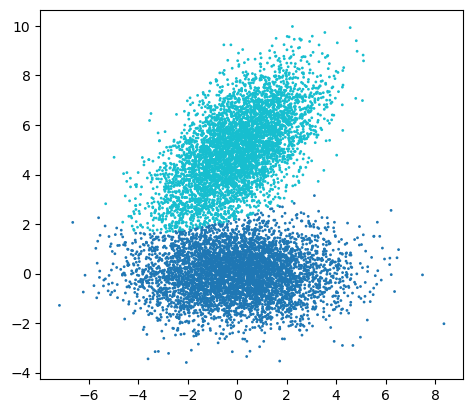

In [53]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
ax.set_aspect('equal')

In [54]:
kspaces.model_selection(points, s1, [s0])

BIC model is lower
82898.2261774424 < 88752.21928356228


'model'

## example 4

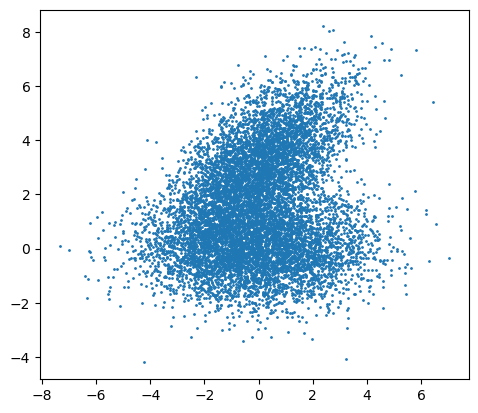

In [55]:
ground_truth = [kspaces.affine_subspace([[1,0]],[0,0],1,[2],1), kspaces.affine_subspace([[1,1]],[0,3],1,[2],1) ]
points = kspaces.generate(ground_truth, size = 10000)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1)

ax.set_aspect('equal')

**Two lines > one line**

In [56]:
s0 = kspaces.fit_single_space(points,1) #one line
p0 = np.array([[1]]*10000)

In [57]:
s1, p1 = kspaces.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 5) #two lines

Converged on iteration 95
Converged on iteration 118
Converged on iteration 141
Converged on iteration 146
Converged on iteration 144
time per EM run: 0.286
time per E, M step : [0.0011 0.0011]


In [58]:
np.sum(np.argmax(p1, axis = 1) ==1) # if this is 0 or 10000, then all the points are hard-assigned to one space

4669

In [59]:
def get_line(s,n_devs = 2):
    latent_sigma = s.latent_sigmas[0]
    return np.vstack([s.translation - n_devs*latent_sigma*s.vectors[0],s.translation + n_devs*latent_sigma*s.vectors[0]]).T

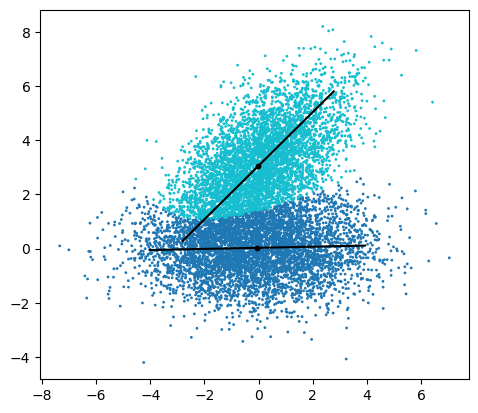

In [60]:
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 1, c = np.argmax(p1, axis = 1), cmap = 'tab10')
l0 = get_line(s1[0])
ax.plot(l0[0],l0[1], c = 'black')
ax.scatter([s1[0].translation[0]],[s1[0].translation[1]], s = 10, c = 'black')

l1 = get_line(s1[1])
ax.plot(l1[0],l1[1], c = 'black')
ax.scatter([s1[1].translation[0]],[s1[1].translation[1]], s = 10, c = 'black')

ax.set_aspect('equal')

In [61]:
kspaces.model_selection(points, s1, [s0])

BIC model is lower
79618.98963236324 < 81816.35731643492


'model'

# Model selection with ICL vs BIC

Let's overlay two subspaces but give one of them a greater noise than the other. It's hard to see by eye, but there is more density near the middle than would be expected given a single Gaussian distribution.

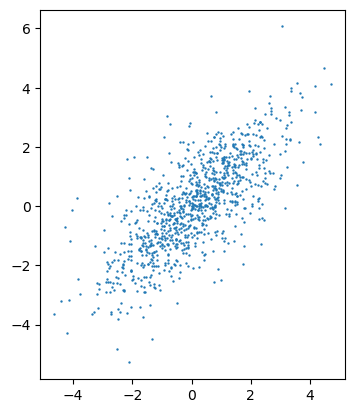

In [62]:
ground_truth = [kspaces.affine_subspace([[1,1]],[0,0],1,[2],0.5), kspaces.affine_subspace([[1,1]],[0,0],0.5,[2],0.5) ]
points = kspaces.generate(ground_truth, size = 1000, seed = 3)
fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 0.5)

ax.set_aspect('equal')

The subtle extra density is picked up by k-spaces (shown below) but in some clustering contexts, we want model selection to say there is 1 subspace, not 2, because the subspaces or having distinct clusters are the primary goal(s), and the probability distribution is secondary.  

max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
max iteration 200 completed
Converged on iteration 123
time per EM run: 0.087
time per E, M step : [0.0001 0.0003]


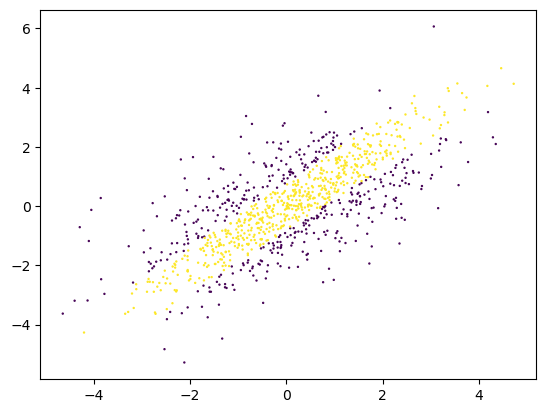

In [63]:
np.random.seed(0)
s1, p1 = kspaces.run_EM(points,[1,1],assignment = 'soft', tol = 1e-5, max_iter = 200, initializations = 10)

fig, ax = plt.subplots()
ax.scatter(points.T[0], points.T[1], s = 0.5, c = np.argmax(p1, axis = 1))
plt.show()

The default model selection is BIC, and it is based on the number of free parameters and the observed data likelihood (i.e., how well the probability density fits the data). It prefers the model with k = 2.

In [64]:
kspaces.model_selection(points, s1, kspaces.fit_single_space(points,1), test = 'BIC')

BIC model is lower
6650.203185457965 < 6660.583991447907


'model'

One option is to use the Integrated Completed Likelihood, which penalizes for uncertainty in clustering assignments for points.

C. Biernacki, G. Celeux, and G. Govaert. Assessing a mixture model for clustering with the integrated completed likelihood. IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(7):719–725, July 2000. 

In [65]:
kspaces.model_selection(points, s1, kspaces.fit_single_space(points,1), test = 'ICL')

ICL model is not lower


'null'